<a href="https://colab.research.google.com/github/oriol-pomarol/codegeo_workshops/blob/main/7_exploring_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8. Hybrid modelling - Integrating ML with process-based simulations

In this series of workshops we have shown how ML models can effectively learn from any data that we feed them. However, in science, a large corpus of knowledge has been acquired in the form of equations and other theoretical knowledge. It would be great to use that knowledge to inform our ML models, allowing them to improve their predictions, right? That's exactly what we are going to do by exploring the world of hybrid modelling; models that combine process-based simulations with machine learning models to (hopefully) improve both.

## 8.1 Introduction to hybrid modelling

### Why Hybrid Models?
Combining process-based models with machine learning offers several advantages:
-  **Consistency with physical knowledge**: ML models can violate physical laws (e.g., conservation of mass). Hybrid models can enforce these constraints.
-  **Smaller data requirements**: Physical models provide a strong prior, reducing the amount of training data needed for the ML component.
-  **Extrapolation**: Physical models generalize better to unseen conditions (e.g., climate change scenarios) than pure ML models.

### Introducing Scientific Knowledge (Willard et al., 2023)
There are three main ways to introduce scientific knowledge into ML:
1.  **Loss Function**: Adding physical constraints (e.g., energy conservation) to the loss function.
2.  **Initialization**: Pre-training the ML model on simulated data from a physical model, then fine-tuning on observations. **We will focus on this approach.**
3.  **Architecture**: Designing the neural network architecture to reflect physical processes (e.g., mass balance layers).

### Types of Hybrid Models (Reichstein et al., 2019)
Hybrid models can be categorized into:
1.  **Improving Parameterizations**: Using ML to estimate parameters for physical models.
2.  **Replacing a Sub-model**: Replacing a computationally expensive or poorly understood physical process with an ML model.
3.  **Model-Observation Mismatch**: Using ML to correct the errors of a physical model. **We will focus on this.**
    *   **Input Coupling**: Feeding the physical model output as an input to the ML model.
    *   **Residual Modelling**: Predicting the residual (error) of the physical model and adding it to the physical prediction.
4.  **Constraining Submodels**: Using physical knowledge to constrain ML predictions.
5.  **Surrogate Modelling**: Emulating the entire physical model with ML for speed.

## 8.2 Problem Description and Data

We aim to predict streamflow (discharge) at Basel. We will use the same dataset as in the first workshop, which includes meteorological variables (precipitation, temperature, evapotranspiration) and the observed discharge at Basel.

![picture](images/basel_discharge.jpg)

Additionally, we will use the simulated discharge from the **PCR-GLOBWB** global hydrological model. PCR-GLOBWB simulates the water cycle based on physical equations. We will use its output ('pcr') as a representation of physical knowledge.

We first import the necessary libraries and load the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Load data
input_data = pd.read_csv("https://raw.githubusercontent.com/oriol-pomarol/final_thesis_project/main/data/pred_basel.csv", delimiter=",", on_bad_lines='skip', index_col=0)
output_data = pd.read_csv("https://raw.githubusercontent.com/oriol-pomarol/final_thesis_project/main/data/q_basel.csv", delimiter = ",", on_bad_lines='skip', index_col=0)

# Select variables, including the physical model output 'pcr'
# Note: We assume the column 'pcr' exists in the input dataset representing the PCR-GLOBWB simulation.
input_data = input_data[['p', 't', 'et']]
output_data = output_data[['obs', 'pcr']]

# Drop missing values
combined = pd.concat([input_data, output_data], axis=1).dropna()
input_data = combined[['p', 't', 'et', 'pcr']]
output_data = combined[['obs']]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.1, shuffle=False)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 6574, Test samples: 731


### Baseline: PCR-GLOBWB Performance

Before building any hybrid models, it is important to establish a baseline. How well does the physical model (PCR-GLOBWB) perform on its own?

In [2]:
# Evaluate PCR-GLOBWB directly
pcr_r2 = r2_score(y_test, X_test['pcr'])
pcr_rmse = root_mean_squared_error(y_test, X_test['pcr'])

print("Physical Model Performance (PCR-GLOBWB):")
print(f"R2: {pcr_r2:.3f}")
print(f"RMSE: {pcr_rmse:.3f}")

Physical Model Performance (PCR-GLOBWB):
R2: 0.227
RMSE: 487.852


## 8.3 Hybrid Modelling under Data Scarcity

We will first explore a scenario of **data scarcity**. Imagine we have a physical model (PCR-GLOBWB) that provides simulations for the entire period, but we only have a few real-world observations of discharge to train our ML models.

We will compare two approaches:
1.  **Pure ML**: Trained only on the few available observations.
2.  **Initialization**: Pre-trained on the abundant physical model simulations, then fine-tuned on the few observations.


In [3]:
# Simulate Data Scarcity
# We use only 10% of the training data for the "observed" part.
# This simulates a scenario where we have a good physical model (simulation) but few real-world measurements.
X_train_scarce = X_train.sample(frac=0.10, random_state=42)
y_train_scarce = y_train.loc[X_train_scarce.index]

print(f"Full Training samples: {len(X_train)}")
print(f"Scarce Training samples: {len(X_train_scarce)}")

Full Training samples: 6574
Scarce Training samples: 657


### Pure ML Model (Scarce Data)

First, we train a standard Random Forest using only the scarce meteorological inputs. This model has to learn the rainfall-runoff relationship from very few examples.

In [9]:
# Train MLP Regressor with ONLY scarce meteo inputs
X_train_meteo_scarce = X_train_scarce[['p', 't', 'et']]
X_test_meteo = X_test[['p', 't', 'et']]

model_pure = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42)
model_pure.fit(X_train_meteo_scarce, y_train_scarce.values.ravel())

# Predict
pred_pure = model_pure.predict(X_test_meteo)

# Evaluate
pure_r2 = r2_score(y_test, pred_pure)
pure_rmse = root_mean_squared_error(y_test, pred_pure)

print("Pure ML Model (Scarce) Performance:")
print(f"R2: {pure_r2:.3f}")
print(f"RMSE: {pure_rmse:.3f}")

Pure ML Model (Scarce) Performance:
R2: -0.056
RMSE: 570.278


### Initialization (Pre-training with Scarce Data)

Now we use the Initialization approach.
1.  **Pre-training**: We use the **full** set of physical model simulations (`X_train['pcr']`) to pre-train the network. This is possible because physical model outputs are usually available for the whole domain/period.
2.  **Fine-tuning**: We then fine-tune the network using only the **scarce** observed data (`y_train_scarce`).


In [19]:
# Initialize MLP Regressor
# warm_start=True allows us to continue training
model_init = MLPRegressor(hidden_layer_sizes=(64, 64), random_state=42, max_iter=1000, warm_start=True)

# Step 1: Pre-train on PCR-GLOBWB output
# We want the model to learn the mapping from Meteo -> PCR
print("Pre-training on Physical Model...")
model_init.fit(X_train[['p', 't', 'et']], X_train['pcr'])

# Check how well it learned PCR
pcr_pred_init = model_init.predict(X_test[['p', 't', 'et']])
init_pcr_r2 = r2_score(X_test['pcr'], pcr_pred_init)
print(f"Pre-training R2 on PCR: {init_pcr_r2:.3f}")

Pre-training on Physical Model...
Pre-training R2 on PCR: 0.206
Pre-training R2 on PCR: 0.206


In [20]:
# Step 2: Fine-tune on Scarce Observed Data
print("Fine-tuning on Scarce Observations...")
model_init.fit(X_train_meteo_scarce, y_train_scarce.values.ravel())

# Predict
pred_init = model_init.predict(X_test_meteo)

# Evaluate
init_r2 = r2_score(y_test, pred_init)
init_rmse = root_mean_squared_error(y_test, pred_init)

print("Initialization (Scarce) Performance:")
print(f"R2: {init_r2:.3f}")
print(f"RMSE: {init_rmse:.3f}")

Fine-tuning on Scarce Observations...
Initialization (Scarce) Performance:
R2: -0.028
RMSE: 562.713
Initialization (Scarce) Performance:
R2: -0.028
RMSE: 562.713


### Data augmentation

In [41]:
# Train a RF model on a concatenation of both observed and PCR outputs
X_train_augmented = pd.concat([X_train_meteo_scarce, X_train[['p', 't', 'et']]], axis=0, ignore_index=True)
y_train_augmented = pd.concat([y_train_scarce.squeeze(), X_train['pcr']], axis=0, ignore_index=True)

model_augmented = MLPRegressor(hidden_layer_sizes=(64, 64), random_state=42, max_iter=1000, warm_start=True)
model_augmented.fit(X_train_augmented, y_train_augmented.values.ravel())

# Predict
pred_augmented = model_augmented.predict(X_test_meteo)

# Evaluate
augmented_r2 = r2_score(y_test, pred_augmented)
augmented_rmse = root_mean_squared_error(y_test, pred_augmented)

print("Augmented Training Performance:")
print(f"R2: {augmented_r2:.3f}")
print(f"RMSE: {augmented_rmse:.3f}")

Augmented Training Performance:
R2: 0.137
RMSE: 515.493


Comparison under Data Scarcity:


,Model,R2,RMSE
0,Pure ML (Scarce),-0.055638,570.278106
1,Initialization (Scarce),-0.027818,562.713497
2,Augmented (Scarce),0.137446,515.492581


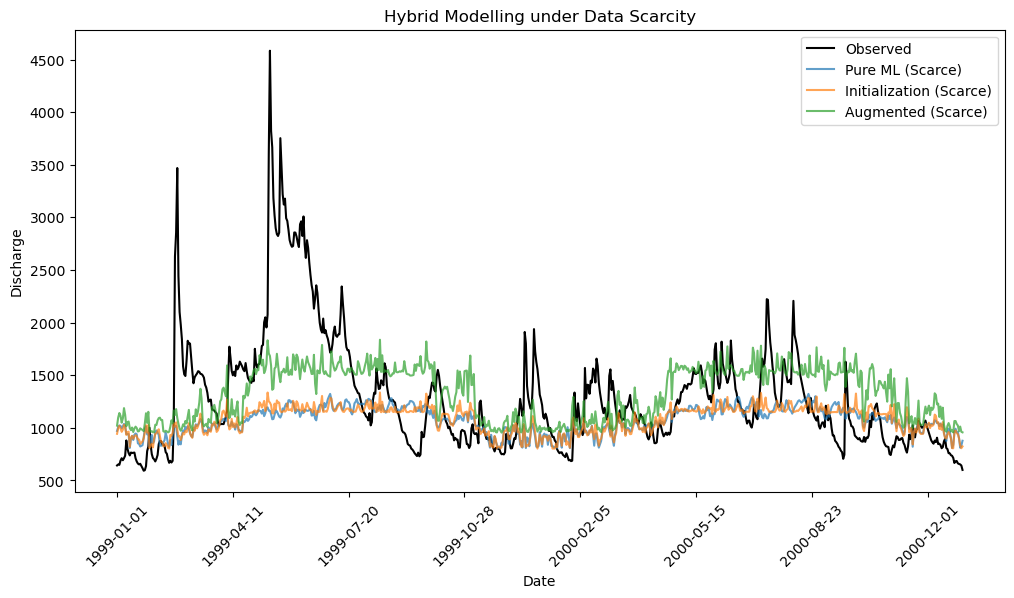

In [42]:
# Compare Pure ML (Scarce) vs Initialization (Scarce)
print("Comparison under Data Scarcity:")
display(pd.DataFrame({
    'Model': ['Pure ML (Scarce)', 'Initialization (Scarce)', 'Augmented (Scarce)'],
    'R2': [pure_r2, init_r2, augmented_r2],
    'RMSE': [pure_rmse, init_rmse, augmented_rmse]
}))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test['obs'], label='Observed', color='black')
plt.plot(y_test.index, pred_pure, label='Pure ML (Scarce)', alpha=0.7)
plt.plot(y_test.index, pred_init, label='Initialization (Scarce)', alpha=0.7)
plt.plot(y_test.index, pred_augmented, label='Augmented (Scarce)', alpha=0.7)
plt.legend()
plt.title('Hybrid Modelling under Data Scarcity')
plt.ylabel('Discharge')
plt.xlabel('Date')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.show()

## 8.4 Hybrid Modelling for Error Correction

### Pure ML Model (Full Data)

In [14]:
# Train Random Forest with FULL meteo inputs
X_train_meteo_full = X_train[['p', 't', 'et']]

model_pure_full = RandomForestRegressor(random_state=42)
model_pure_full.fit(X_train_meteo_full, y_train.values.ravel())

# Predict
pred_pure_full = model_pure_full.predict(X_test_meteo)

# Evaluate
pure_full_r2 = r2_score(y_test, pred_pure_full)
pure_full_rmse = root_mean_squared_error(y_test, pred_pure_full)

print("Pure ML Model (Full Data) Performance:")
print(f"R2: {pure_full_r2:.3f}")
print(f"RMSE: {pure_full_rmse:.3f}")

Pure ML Model (Full Data) Performance:
R2: 0.073
RMSE: 534.503


### Model-observation mismatch

In this section, we assume we have access to the **full** set of observed data. We want to see if combining the physical model with ML can outperform a pure ML model trained on the same full dataset. We will explore two methods:
1.  **Input Coupling**: Using the physical model output as an input feature.
2.  **Residual Modelling**: Predicting the error (residual) of the physical model.

In [15]:
# Train Random Forest with p, t, et, AND pcr as inputs
model_input = RandomForestRegressor(random_state=42)
model_input.fit(X_train, y_train.values.ravel())

# Predict
pred_input = model_input.predict(X_test)

# Evaluate
input_r2 = r2_score(y_test, pred_input)
input_rmse = root_mean_squared_error(y_test, pred_input)

print("Method 1 (Input Coupling) Performance:")
print(f"R2: {input_r2:.3f}")
print(f"RMSE: {input_rmse:.3f}")

Method 1 (Input Coupling) Performance:
R2: 0.568
RMSE: 365.005


In [16]:
# Calculate Residuals (Observed - Physical Model)
residuals_train = y_train['obs'] - X_train['pcr']

# Train Random Forest to predict residuals from meteo data
model_resid = RandomForestRegressor(random_state=42)
model_resid.fit(X_train_meteo_full, residuals_train)

# Predict residuals on test set
pred_residuals = model_resid.predict(X_test_meteo)

# Final prediction = Physical Model + Predicted Residual
pred_resid_model = X_test['pcr'] + pred_residuals

# Evaluate
resid_r2 = r2_score(y_test, pred_resid_model)
resid_rmse = root_mean_squared_error(y_test, pred_resid_model)

print("Residual Modelling Performance:")
print(f"R2: {resid_r2:.3f}")
print(f"RMSE: {resid_rmse:.3f}")

Residual Modelling Performance:
R2: 0.565
RMSE: 366.222


Comparison for Error Correction:


,Model,R2,RMSE
0,Pure ML (Full),0.072655,534.502771
1,Input Coupling,0.567547,365.004687
2,Residual Modelling,0.564658,366.221921


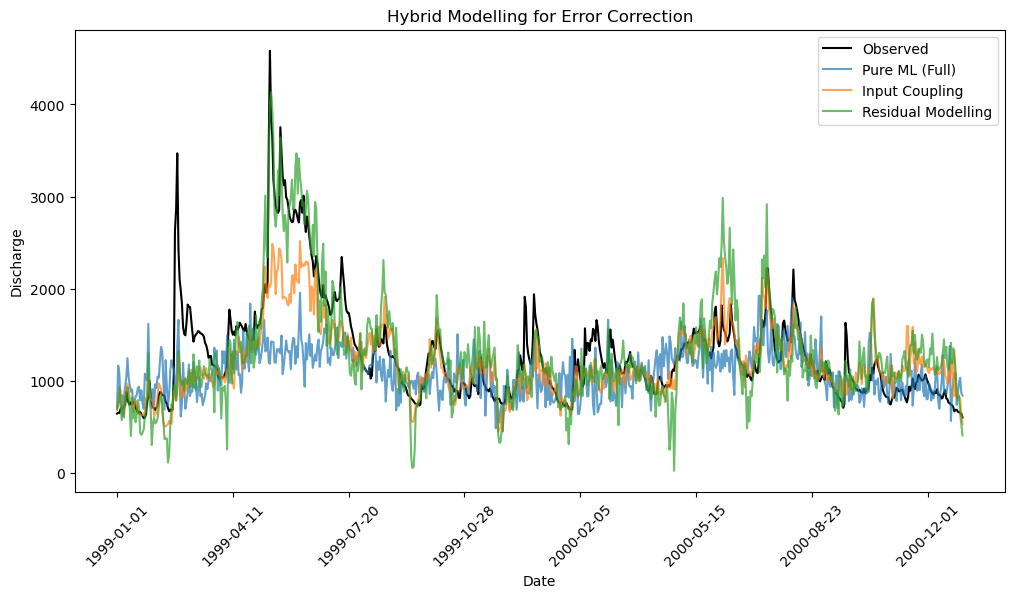

In [22]:
# Compare Pure ML (Full), Input Coupling, and Residual Modelling
print("Comparison for Error Correction:")
display(pd.DataFrame({
    'Model': ['Pure ML (Full)', 'Input Coupling', 'Residual Modelling'],
    'R2': [pure_full_r2, input_r2, resid_r2],
    'RMSE': [pure_full_rmse, input_rmse, resid_rmse]
}))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test['obs'], label='Observed', color='black')
plt.plot(y_test.index, pred_pure_full, label='Pure ML (Full)', alpha=0.7)
plt.plot(y_test.index, pred_input, label='Input Coupling', alpha=0.7)
plt.plot(y_test.index, pred_resid_model, label='Residual Modelling', alpha=0.7)
plt.legend()
plt.title('Hybrid Modelling for Error Correction')
plt.ylabel('Discharge')
plt.xlabel('Date')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.show()